<a href="https://colab.research.google.com/github/yum-cloud-94/Algorithmic-Trading-Project/blob/master/Algorithmic_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic Trading Project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cvxopt as opt
from cvxopt import solvers
import warnings

# ETF 주가 불러오기

In [3]:
data = pd.read_excel('/content/drive/My Drive/SNU 빅데이터 핀테크/알고리즘트레이딩/ETF.xlsx', sheet_name='주가')
data.head()

,Name,KODEX 200,KOSEF 200,KODEX 반도체,KODEX 은행,KODEX 자동차,TIGER KRX100,TIGER 은행,TIGER 반도체,TIGER 방송통신,KODEX China H,KOSEF KRX100,KODEX 일본TOPIX100,TIGER 200,KODEX 삼성그룹,KODEX 기계장비,KODEX 증권,KOSEF 블루칩,KOSEF 고배당,TIGER 라틴35,KINDEX 200,KBSTAR 5대그룹주,KINDEX 삼성그룹섹터가중,TREX 200,KBSTAR 국고채3년,KODEX 국고채3년,KINDEX 중기국고채,KOSEF 국고채3년,KODEX 인버스,TIGER 국채3년,KODEX 에너지화학,KODEX 철강,TIGER 차이나항셍25,KODEX 건설,ARIRANG 코스피50,KOSEF 통안채1년,KODEX 레버리지,TIGER 인버스,TIGER 레버리지,TIGER 원유선물Enhanced(H),...,KINDEX 코스피,TIGER 미국채10년선물,TIGER 2차전지테마,KODEX 2차전지산업,HANARO 200선물인버스,HANARO 코스닥150선물레버리지,HANARO 단기통안채,KODEX KRX300레버리지,KODEX KRX300선물인버스,KBSTAR KRX300레버리지,KBSTAR KRX300선물인버스,TIGER 의료기기,TIGER 지주회사,TIGER KRX300레버리지,TIGER KRX300선물인버스,KODEX 미국채10년선물,ARIRANG KRX300IT,ARIRANG KRX300금융,ARIRANG KRX300산업재,ARIRANG KRX300자유소비재,ARIRANG KRX300헬스케어,KINDEX 미국WideMoat가치주,KBSTAR 중국MSCI China선물(H),TIGER 200TR,TIGER MSCI Korea TR,KODEX 미국FANG플러스(H),HANARO 농업융복합산업,TIGER 200커뮤니케이션서비스,KBSTAR 200커뮤니케이션서비스,KODEX Top5PlusTR,KBSTAR 대형고배당10TR,KINDEX 싱가포르리츠,KOSEF 코스닥150,TIGER 골드선물(H),KBSTAR KRX300미국달러선물혼합,KINDEX 스마트퀄리티,KINDEX 스마트로우볼,KINDEX 스마트하이베타,HANARO e커머스,HANARO 고배당
0,2008-01-02,20269,20727,11495,8876,6826,32556,8896,10608,8646,19165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-01-03,20247,20788,11388,8777,7036,32548,8788,10589,8584,18770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-04,20341,20845,10958,8802,6826,32671,8800,10608,8700,18825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-01-07,19929,20475,10654,8673,6780,31960,8655,10340,8514,18605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-01-08,19861,20418,10586,8594,6734,31823,8589,10275,8382,18970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.columns

Index(['Name', 'KODEX 200', 'KOSEF 200', 'KODEX 반도체', 'KODEX 은행', 'KODEX 자동차',
       'TIGER KRX100', 'TIGER 은행', 'TIGER 반도체', 'TIGER 방송통신',
       ...
       'KBSTAR 대형고배당10TR', 'KINDEX 싱가포르리츠', 'KOSEF 코스닥150', 'TIGER 골드선물(H)',
       'KBSTAR KRX300미국달러선물혼합', 'KINDEX 스마트퀄리티', 'KINDEX 스마트로우볼',
       'KINDEX 스마트하이베타', 'HANARO e커머스', 'HANARO 고배당'],
      dtype='object', length=427)

### ETF 2가지 선정
- TIGER 방송통신  
- KODEX 건설

In [5]:
new_data = data[['TIGER 방송통신','KODEX 건설']] # 0.7064 : 0.2936

new_data.index = data.Name
new_data = new_data.loc['2016-09-01':]

# 선정된 ETF Efficient Frontier 집합 구하기

### 한 달(20일) 주기로 returns 구하기

In [6]:
holding_periods = 20
n_term = 12

returns = new_data.pct_change(holding_periods).iloc[holding_periods:] 
exp_rets = returns.mean() * n_term 
cov_mat = returns.cov() * n_term 
corr_mat = returns.corr() 

In [7]:
returns

,TIGER 방송통신,KODEX 건설
Name,,
2016-10-05,0.021609,0.011708
2016-10-06,0.021729,0.025570
2016-10-07,0.002743,0.020185
2016-10-10,0.010457,0.030553
2016-10-11,0.018772,0.047603
...,...,...
2019-04-22,-0.030148,0.024430
2019-04-23,-0.025707,0.016103
2019-04-24,-0.026667,0.008091


In [8]:
def mean_var_portfolio(cov_mat, exp_rets, target_ret) :

  n = len(cov_mat)

  # Objective function
  P = opt.matrix(cov_mat.values)
  q = opt.matrix(0.0, (n, 1))

  # Constraints Gw <= h
  G = opt.matrix(np.vstack((-exp_rets.values, -np.identity(n))))
  h = opt.matrix(np.vstack((-target_ret, np.zeros((n, 1)))))

  # Constraints Aw = b 
  A = opt.matrix(1.0, (1, n))
  b = opt.matrix(1.0)

  # Solve
  solvers.options['show_progress'] = False
  sol = solvers.qp(P, q, G, h, A, b)

  # Put weights into a labeled series
  w = pd.Series(sol['x'], index = cov_mat.index)

  return w

In [9]:
max_risk = 0.5
max_ret = exp_rets.max()
min_ret = exp_rets[exp_rets > 0].min()

n_step = 10000
step_diff = (max_ret - min_ret) / n_step

risks = []
rets = []
weights = []

for step in range(n_step):
  target_ret = min_ret + (step * step_diff)
  _w =  mean_var_portfolio(cov_mat, exp_rets, target_ret)
  risk = np.sqrt(np.dot(np.dot(_w, cov_mat), _w))

  if risk > max_risk :
    break

  risks.append(risk)
  ret = np.dot(exp_rets, _w)
  rets.append(ret)
  weights.append(_w)

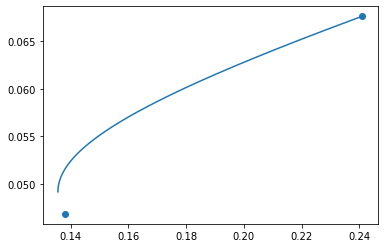

In [10]:
# plt.figure(figsize=(15,10))
plt.plot(risks, rets)
var = np.diag(cov_mat)
plt.scatter(np.sqrt(var), exp_rets)
plt.show()

# Tangency portfolio 최종 구축 완성형 포트폴리오

In [11]:
rf_rate = 0.0075
 
slopes = []

for i in range(len(risks)):
  slope_ = (rets[i] - rf_rate) / risks[i]
  slopes.append(slope_)
 
max_tangency_idx = np.argmax(slopes)
max_tangency = slopes[max_tangency_idx]
max_tangency_risk = risks[max_tangency_idx]
max_tangency_return = rets[max_tangency_idx]
max_tangency_weight = weights[max_tangency_idx]
 
print("Risk of tangency portfolio : ", max_tangency_risk)
print("Return of tangency portfolio : ", max_tangency_return)
print("Sharpe ratio of tangency portfolio : ", (max_tangency_return - rf_rate) / max_tangency_risk)
print("Weight of minimum variance portfolio : ")
print(max_tangency_weight)

Risk of tangency portfolio :  0.14160775304850587
Return of tangency portfolio :  0.05294636095936616
Sharpe ratio of tangency portfolio :  0.3209313048262203
Weight of minimum variance portfolio : 
TIGER 방송통신    0.7064
KODEX 건설      0.2936
dtype: float64


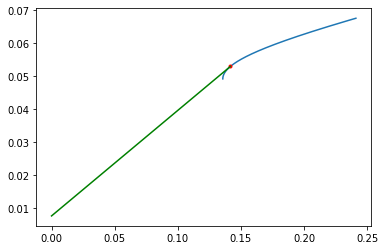

In [12]:
CAL_x = [0, max_tangency_risk]
CAL_y = [rf_rate, max_tangency_return]

plt.plot(risks, rets)
plt.plot(max_tangency_risk, max_tangency_return, marker = '.', color= 'r')
plt.plot(CAL_x, CAL_y, color = 'g')
# plt.xlim(0,1,10)
# plt.ylim(0,0.5,10)
plt.show()

# 백테스팅

### 한 달(20일) 기준 수익률 계산

In [13]:
def create_data(data):
  
  result = data.pct_change(20).iloc[20:]
  
  returns = result
  avg_rets = returns.mean()*12
  cov_mat = returns.cov()*12

  return returns, cov_mat, avg_rets

In [14]:
create_data(new_data)

(            TIGER 방송통신  KODEX 건설
 Name                            
 2016-10-05    0.021609  0.011708
 2016-10-06    0.021729  0.025570
 2016-10-07    0.002743  0.020185
 2016-10-10    0.010457  0.030553
 2016-10-11    0.018772  0.047603
 ...                ...       ...
 2019-04-22   -0.030148  0.024430
 2019-04-23   -0.025707  0.016103
 2019-04-24   -0.026667  0.008091
 2019-04-25   -0.034289  0.013008
 2019-04-26   -0.026846 -0.006319
 
 [628 rows x 2 columns],             TIGER 방송통신  KODEX 건설
 TIGER 방송통신    0.019015  0.013396
 KODEX 건설      0.013396  0.058096, TIGER 방송통신    0.046854
 KODEX 건설      0.067604
 dtype: float64)

### Risk Free Rate 구하기

In [15]:
risk_free = data['KOSEF 단기자금']
risk_free.index = data.Name
risk_free = risk_free.loc['2017-01-01':]

In [16]:
holding_periods = 20
n_term = 12 # dailiy return을 annualize

rf_returns = risk_free.pct_change(holding_periods).iloc[holding_periods:] # holding period return vector, NAN 값 이후부터 불러옴
rf_rate = rf_returns.mean() * n_term  # avarage return -- > APR(Annual Percentage Rate)

In [17]:
rf_rate

0.01519047822739623

### Tangency portfolio의 위험 자산을 KOSEF 단기자금으로 설정

In [18]:
def tangency_portfolio(cov_mat, exp_rets, target_ret, min_rets, max_rets, rf_rate = rf_rate):
  
  n = len(cov_mat)
  P = opt.matrix(cov_mat.values)
  q = opt.matrix(0.0, (n, 1))
  
  tangency_queue = []
  weights_queue = []
  return_queue = []
  cov_queue = []
  
  step = (max_rets - min_rets)/500
  minus_cnt = 0
  
  for i in range(500):
              
      try:
      
          target_ret = min_rets + (i * step)

          # Constraints Gx <= h

          G = opt.matrix(np.vstack((-exp_rets.values, -np.identity(n))))
          h = opt.matrix(np.vstack((-target_ret, np.zeros((n, 1)))))

          # Constraints Ax = b
          # sum(x) = 1
          A = opt.matrix(1.0, (1, n))
          b = opt.matrix(1.0)

          solvers.options['show_progress'] = False
          sol = solvers.qp(P, q, G, h, A, b)

          if sol['status'] != 'optimal':
              warnings.warn("Convergence problem")
              pass

          # Put weights into a labeled series
          weights = pd.Series(sol['x'], index=cov_mat.index)
          
          tangency_ = (np.dot(exp_rets, weights) - rf_rate) / np.sqrt(np.dot(np.dot(weights, cov_mat), weights))
          tangency_queue.append(tangency_)
          weights_queue.append(weights)
          return_queue.append(np.dot(exp_rets, weights))
          cov_queue.append(np.sqrt(np.dot(np.dot(weights, cov_mat), weights)))
      
      except:
          pass

  
  tan_index = tangency_queue.index(max(tangency_queue))
  
  weights = weights_queue[tan_index]

  return weights

### 3달 기준으로 백테스팅

In [19]:
def back_test(data, window_size):

    # Window_size는 tangency portfolio를 구할 때 이전 몇 달의 데이터를 사용할 것인지 나타낸다.

    total_days = data.shape[0]
    
    # Rebalancing을 한 달마다 진행하는 경우, 'M'으로 rebalance_period는 20이 된다.
    rebalance_period = 20

    returns, cov_mat, avg_rets= create_data(data)
    
    # n_rebalance : 총 몇 번의 리밸런싱을 하게 되는지?
    n_rebalance = int(returns.shape[0]/20) - window_size
    w = []
    rebalancing_date=[]
    original_weights = []
    
    for i in range(n_rebalance, -1, -1): # n_rebalance, ... , 1, 0 까지 도는 코드
        
        # N일에 리밸런싱을 할 때에는 Tangency portfolio weight를 새로 구해야 한다. 이 때 N - window_size * rebalance_period부터 N - 1일 까지의 데이터를 사용한다.
        _returns, _cov_mat, _avg_rets= create_data(data.iloc[total_days - (window_size + i) * rebalance_period:
                                                             total_days - i * rebalance_period])
        rebalancing_date.append(data.index[total_days - i * rebalance_period - 1])

        _target_ret = _avg_rets.quantile(0.7)
        _min_ret = _avg_rets.min()
        _max_ret = _avg_rets.max()

        _w = np.asarray(tangency_portfolio(_cov_mat, _avg_rets, _target_ret, _min_ret, _max_ret).values)
        _w = _w.reshape(_w.shape[0],1)
        original_weights.append(_w)
        w.append(_w)

    price = data.T
    price = np.array(price)
    
    port = [] # 여기에 날마다 변하는 Portfolio value를 저장한다.
    port_date = [] # 여기에 portfolio의 data를 저장한다.
    portfolio_value = 10000
    port_weight = [] # 그 날의 portfolio의 구성이다. Ex) 만약 Asset1에 6000원, Asset2에 4000원, 나머지에 0원이 있다면 [6000, 4000, 0, 0, 0]이 된다.
    
    for i in range(n_rebalance, 0, -1):
        
        for j in range(rebalance_period):

            if j==0:

                # 리밸런싱을 하는 날이다. Portfolio value를 새로운 tangency portfolio weight로 맞춰준다.
                port_weight = portfolio_value * w[n_rebalance - i].T[0]

                # port_weight의 값을 다 더한 게 그 날의 portfolio_value가 된다.
                portfolio_value = port_weight.sum()

                # port에 portfolio_value를 저장하여 준다.
                port.append(portfolio_value)
                
            else:

                # 여기는 리밸런싱이 아닌, 그냥 날짜가 지나는 부분이다. 각 날마다 자산의 가격이 바뀌므로, 리밸런싱을 하지 않아도 가격을 따라 port_weight가 변화한다.
                port_weight = port_weight * (price[:, total_days - i * rebalance_period + j] / 
                                             price[:, total_days - i * rebalance_period + j - 1])
                
                # port_weight의 값을 다 더한 게 그 날의 portfolio_value가 된다.
                portfolio_value = port_weight.sum()

                # port에 portfolio_value를 저장하여 준다.
                port.append(portfolio_value)
                
            port_date.append(data.index[total_days - i * rebalance_period + j])

            print(port_date[-1], portfolio_value)
    
    portfolio = pd.DataFrame(port, columns = ['portfolio_value'], index = port_date)
    
    return w, portfolio, original_weights, rebalancing_date

In [20]:
new_data = new_data.dropna()
w, portfolio, original_weights, rebalancing_date = back_test(new_data, 3)

2017-01-10 00:00:00 10000.000000000002
2017-01-11 00:00:00 10016.06319115489
2017-01-12 00:00:00 9973.603498822318
2017-01-13 00:00:00 10096.999380147976
2017-01-16 00:00:00 10108.076114147563
2017-01-17 00:00:00 10059.644992304442
2017-01-18 00:00:00 10086.474555992878
2017-01-19 00:00:00 10334.28016183349
2017-01-20 00:00:00 10399.182030505739
2017-01-23 00:00:00 10399.290296133428
2017-01-24 00:00:00 10301.630740513272
2017-01-25 00:00:00 10279.957005273463
2017-01-26 00:00:00 10317.52070666386
2017-01-31 00:00:00 10355.780672068999
2017-02-01 00:00:00 10291.124205486178
2017-02-02 00:00:00 10259.416450270128
2017-02-03 00:00:00 10399.54291593137
2017-02-06 00:00:00 10436.6085954344
2017-02-07 00:00:00 10480.37083929677
2017-02-08 00:00:00 10447.75750651911
2017-02-09 00:00:00 10447.757506519109
2017-02-10 00:00:00 10485.152235871168
2017-02-13 00:00:00 10458.120673483001
2017-02-14 00:00:00 10447.93343998113
2017-02-15 00:00:00 10458.084020678412
2017-02-16 00:00:00 10431.052458290

### 수익률 그래프

In [21]:
portfolio

,portfolio_value
2017-01-10,10000.000000
2017-01-11,10016.063191
2017-01-12,9973.603499
2017-01-13,10096.999380
2017-01-16,10108.076114
...,...
2019-04-22,11405.812439
2019-04-23,11441.972059
2019-04-24,11297.227119
2019-04-25,11297.097001


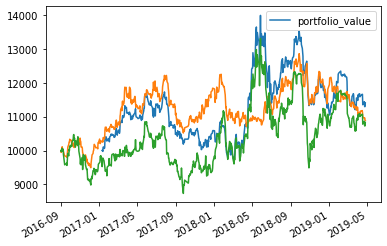

In [22]:
# Backtest Result Plotting
portfolio.plot()
for symbol in ['TIGER 방송통신','KODEX 건설']:
  plt.plot(new_data[symbol] * 10000 / new_data[symbol][0])

plt.show()

### Sharp Ratio

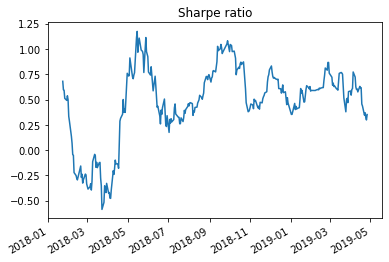

In [23]:
# Sharpe Ratio 계산

new_port = portfolio
new_port['returns'] = new_port['portfolio_value'].pct_change(1)

# Input y에 대해 Sharpe ratio를 구해주는 함수. Sharpe ratio = mean / std 를 연환산해주면 된다.
def my_rolling_sharpe(y):
    return np.sqrt(252) * (y.mean() / y.std())
# Calculate rolling Sharpe ratio
new_port['rs'] = new_port['returns'].rolling(252).apply(my_rolling_sharpe)

new_port['rs'].plot()
plt.title('Sharpe ratio')
plt.show()

In [24]:
new_port

,portfolio_value,returns,rs
2017-01-10,10000.000000,NaN,NaN
2017-01-11,10016.063191,0.001606,NaN
2017-01-12,9973.603499,-0.004239,NaN
2017-01-13,10096.999380,0.012372,NaN
2017-01-16,10108.076114,0.001097,NaN
...,...,...,...
2019-04-22,11405.812439,-0.000002,0.346125
2019-04-23,11441.972059,0.003170,0.369847
2019-04-24,11297.227119,-0.012650,0.323008
2019-04-25,11297.097001,-0.000012,0.298913


### MDD

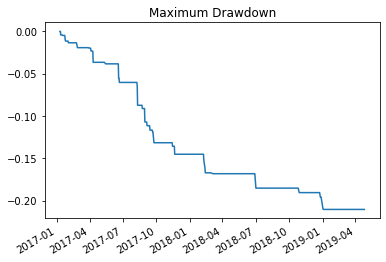

In [25]:
# Maximum Drawdown 계산
# Drawdown이란? 저점과 고점 사이 비율.
# Maximum Drawdown이란? 새 고점에 도달하기 전까지 Drawdown

# 252일을 window로 삼아 MDD를 구해준다.
window = 252

# 이전 252일 중 고점의 값을 Roll_Max에 저장한다.
# Pandas Series.rolling 사용
Roll_Max = portfolio['portfolio_value'].rolling(window, min_periods = 1).max()

# 현재 값과 고점의 비율을 구하여 Daily_Drawdown에 저장한다.
Daily_Drawdown = portfolio['portfolio_value']/Roll_Max - 1.0

# 이전 252일 중 Daily_Drawdown의 최소값을 Max_Daily_Drawdown에 저장한다.
Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods = 1).min()

# Plot the results
Max_Daily_Drawdown.plot()
plt.title('Maximum Drawdown')
plt.show()